In [1]:
from matplotlib import pyplot as plt
from datetime import datetime
import math
import sys
from pprint import pprint

sys.path.append('../..')

In [2]:
from model.amm.omnipool_amm import OmnipoolState, dynamicadd_asset_fee, dynamicadd_lrna_fee, usd_price, lrna_price, price, cash_out_omnipool, value_assets
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices
from datetime import datetime
import math
import random

initial_omnipool_tvl = 10000000
lrna_price_usd = 22.22

omnipool = OmnipoolState(
    tokens={
        'DOT': {'liquidity': 1000000, 'LRNA': 3000000},
        'HDX': {'liquidity': 1000000000, 'LRNA': 100000000},
        'USD': {'liquidity': 10000000, 'LRNA': 10000000}
    },
    lrna_fee=0,
    asset_fee=0,
    withdrawal_fee=False,
    preferred_stablecoin = 'USD',
)

initial_state = omnipool.copy()

agent1 = Agent(
    holdings={'DOT': 1}
)
agent2 = Agent(
    holdings={'DOT': 1}
)
agent3 = Agent(
    holdings={'DOT': 5000000, 'HDX': 20000000}
)


In [3]:
print(omnipool.usd_price(omnipool, 'DOT'))
omnipool.add_liquidity(
    agent=agent1,
    quantity=1,
    tkn_add='DOT'
)
print(agent1.holdings)

3.0
{'DOT': 0, ('omnipool', 'DOT'): 1.0}


In [4]:
omnipool.swap(
    agent=agent3.copy(),
    tkn_sell='DOT',
    tkn_buy='HDX',
    sell_quantity = 500000
)

Omnipool: omnipool
********************************
tvl cap: inf
LRNA imbalance: 0.0
lrna fee:

    DOT: 0%
    HDX: 0%
    USD: 0%

asset fee:

    DOT: 0%
    HDX: 0%
    USD: 0%

asset pools: (

    *DOT*
    asset quantity: 1500001
    lrna quantity: 2000002.6666668889
    USD price: 1.333334222222
    weight: 2000002.6666668889/113000003.0 (0.017699138173181188)
    weight cap: 1
    total shares: 1000001.0
    protocol shares: 1000000

    *HDX*
    asset quantity: 990099006.6333388
    lrna quantity: 101000000.3333331
    USD price: 0.102010000673
    weight: 101000000.3333331/113000003.0 (0.8938052889550198)
    weight cap: 1
    total shares: 1000000000
    protocol shares: 1000000000

    *USD*
    asset quantity: 10000000
    lrna quantity: 10000000
    USD price: 1.0
    weight: 10000000/113000003.0 (0.08849557287179895)
    weight cap: 1
    total shares: 10000000
    protocol shares: 10000000

)
sub pools: (

    
)
oracles: (
    name: price
    length: 9

)

error messa

In [5]:
omnipool.add_liquidity(
    agent=agent2,
    quantity=1,
    tkn_add='DOT'
)
print(agent2.holdings)

{'DOT': 0, ('omnipool', 'DOT'): 0.6666668888887407}


In [6]:
print(agent1, agent2)


Agent: agent
********************************
trade strategy: None
holdings: (

    *DOT*: 0

    *('omnipool', 'DOT')*: 1.0
    price: 3.0
)
 Agent: agent
********************************
trade strategy: None
holdings: (

    *DOT*: 0

    *('omnipool', 'DOT')*: 0.6666668889
    price: 1.3333342222
)



In [8]:
# price_scenarios = []
# for n in range(100, 0, -1):
#     tkn_sell = 'HDX'
#     tkn_buy = 'DOT'
#     sell_quantity = agent3.holdings['HDX'] / 10000 * n ** 2
#     price_scenarios.append(
#         omnipool.copy().swap(
#             agent=agent3.copy(),
#             tkn_sell=tkn_sell,
#             tkn_buy=tkn_buy,
#             sell_quantity=sell_quantity
#         )
#     )
# # price_scenarios.append(omnipool.copy())
# for n in range(0, 100):
#     tkn_sell = 'DOT'
#     tkn_buy = 'HDX'
#     sell_quantity = agent3.holdings['DOT'] / 20 * math.sqrt(n)
#     price_scenarios.append(
#         omnipool.copy().swap(
#             agent=agent3.copy(),
#             tkn_sell=tkn_sell,
#             tkn_buy=tkn_buy,
#             sell_quantity=sell_quantity
#         )
#     )
# steps = len(price_scenarios)

price_min = lrna_price(omnipool, 'DOT') / 10
price_max = lrna_price(omnipool, 'DOT') * 10
steps = 200
log_min = math.log10(price_min)
log_max = math.log10(price_max)

dot_prices = [10**(log_min + i * (log_max - log_min) / (steps - 1)) for i in range(steps)]
k = omnipool.lrna['DOT'] * omnipool.liquidity['DOT']

price_scenarios = [
    OmnipoolState(
        tokens={
            'DOT': {
                'liquidity': math.sqrt(k / dot_prices[i]), 
                'LRNA': math.sqrt(k * dot_prices[i]),
                'shares': omnipool.shares['DOT']
            },
            'HDX': {'liquidity': 1000000000, 'LRNA': 100000000},
            'USD': {'liquidity': 10000000, 'LRNA': 10000000}
        },
        withdrawal_fee=False
    ) for i in range(steps)
]

In [9]:
price_scenarios[0].liquidity['DOT'] / price_scenarios[0].lrna['DOT']

7.4999950000058355

In [10]:
prices = [{tkn: price(pool, tkn, 'DOT') for tkn in pool.asset_list} for pool in price_scenarios]
dot_prices = [lrna_price(pool, 'DOT') for pool in price_scenarios]
agent1_value = [
    cash_out_omnipool(omnipool=pool, agent=agent1, prices=prices[i])
    for i, pool in enumerate(price_scenarios)
]
agent2_value = [
    cash_out_omnipool(omnipool=pool, agent=agent2, prices=prices[i])
    for i, pool in enumerate(price_scenarios)
]

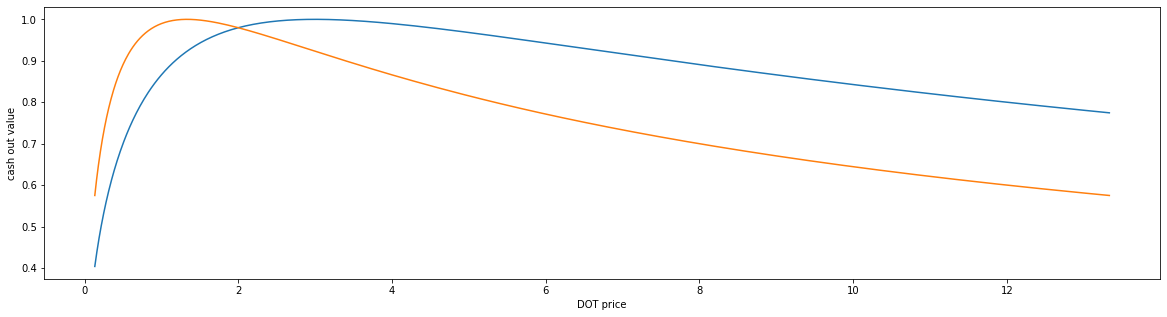

In [14]:
plt.figure(figsize=(20, 5))
plt.plot(dot_prices, agent1_value)
plt.plot(dot_prices, agent2_value)
plt.ylabel('cash out value')
plt.xlabel('DOT price')
# plt.xscale('log')
# plt.yscale('log')
plt.show()

Text(0.5, 0, 'DOT price')

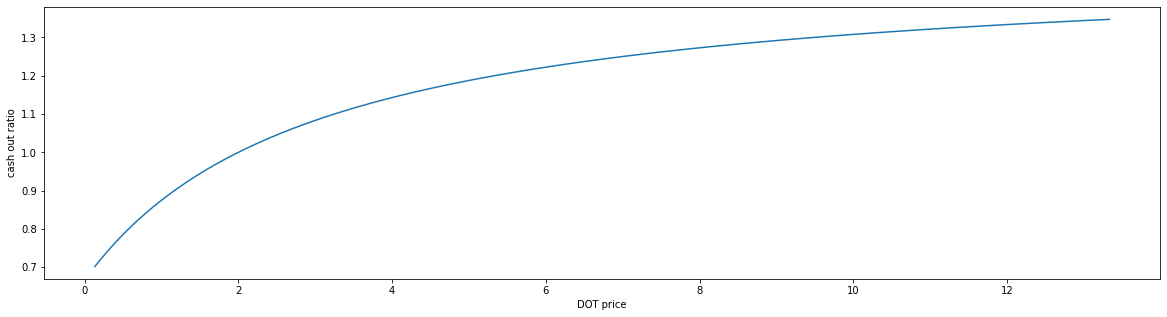

In [15]:
plt.figure(figsize=(20, 5))
plt.plot(dot_prices, [agent1_value[i] / agent2_value[i] for i in range(len(dot_prices))])
plt.ylabel('cash out ratio')
plt.xlabel('DOT price')

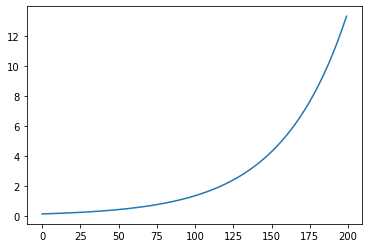

In [16]:
plt.plot(dot_prices)

In [17]:
withdraw_scenarios = []
agent1_holdings = []
agent2_holdings = []
for pool in price_scenarios:
    withdraw_scenario = pool.copy()
    test_agent1 = agent1.copy()
    test_agent2 = agent2.copy()
    withdraw_scenario.remove_liquidity(
        agent=test_agent1,
        tkn_remove='DOT',
        quantity=test_agent1.holdings[('omnipool', 'DOT')]
    )
    withdraw_scenario.remove_liquidity(
        agent=test_agent2,
        tkn_remove='DOT',
        quantity=test_agent2.holdings[('omnipool', 'DOT')]
    )
    agent1_holdings.append(test_agent1.holdings)
    agent2_holdings.append(test_agent2.holdings)

lrna_prices = [1 / lrna_price(pool, 'DOT') for pool in price_scenarios]

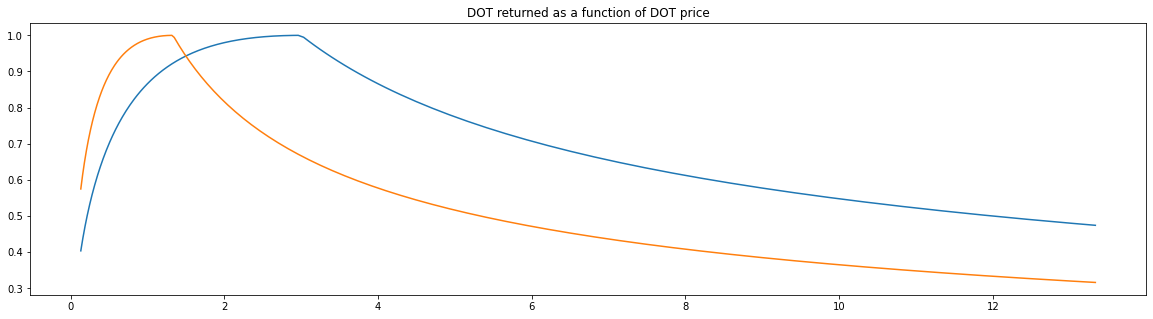

In [18]:
plt.figure(figsize=(20, 5))
plt.plot(dot_prices, [agent1_holdings[i]['DOT'] for i in range(steps)])
plt.plot(dot_prices, [agent2_holdings[i]['DOT'] for i in range(steps)])
plt.title('DOT returned as a function of DOT price')
plt.show()

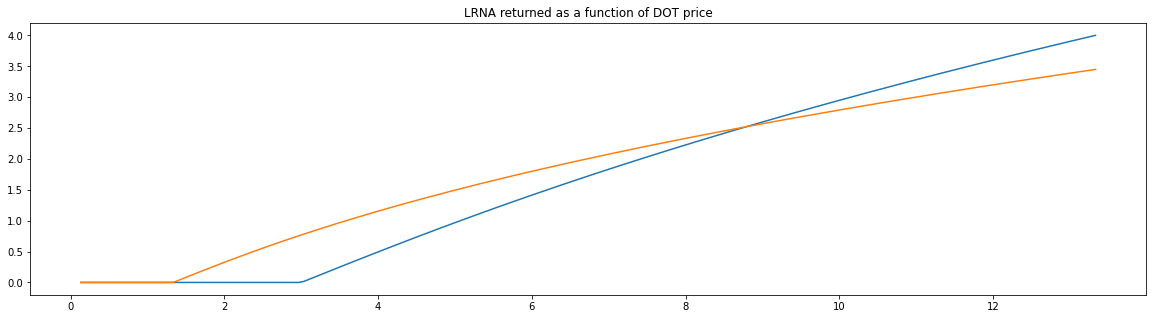

In [19]:
plt.figure(figsize=(20, 5))
plt.plot(dot_prices, [agent1_holdings[i]['LRNA'] if 'LRNA' in agent1_holdings[i] else 0 for i in range(len(agent1_holdings))])
plt.plot(dot_prices, [agent2_holdings[i]['LRNA'] if 'LRNA' in agent2_holdings[i] else 0 for i in range(len(agent2_holdings))])
plt.title('LRNA returned as a function of DOT price')
plt.show()

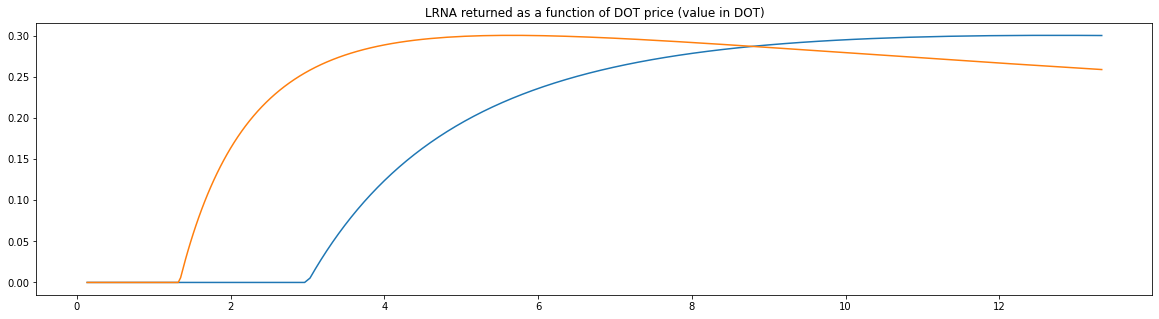

In [20]:
plt.figure(figsize=(20, 5))
plt.plot(dot_prices, [(agent1_holdings[i]['LRNA'] if 'LRNA' in agent1_holdings[i] else 0) / dot_prices[i] for i in range(len(agent1_holdings))])
plt.plot(dot_prices, [(agent2_holdings[i]['LRNA'] if 'LRNA' in agent2_holdings[i] else 0) / dot_prices[i] for i in range(len(agent2_holdings))])
plt.title('LRNA returned as a function of DOT price (value in DOT)')
plt.show()